In [12]:

import os, re, random, math, warnings
from collections import defaultdict

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression as SkLogistic
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

nltk.download('twitter_samples')
nltk.download('stopwords')

all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split data into train and test set
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# Create the numpy array of positive labels and negative labels.
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import string

def process_tweet(tweet):
    """
    Input:
        :tweet: a string
    Output:
        :tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) #the tokenizer will downcase everything except for emoticons
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and   # remove stopwords
                word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

def build_freqs(tweets, ys):
    """ Build frequencies
    Input:
    tweets: a list of tweets
    ys: an mx1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
    freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    yslist = np.squeeze(ys).tolist()
    # start with an empty dict and populate it by looping over all tweets
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [23]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input:
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output:
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)

    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))

    #bias term is set to 1
    x[0,0] = 1
    # loop through each word in the list of words
    for word in word_l:

        # increment the word count for the positive label 1
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]

        # increment the word count for the negative label 0
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]

    assert(x.shape == (1, 3))
    return x

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

import matplotlib.pyplot as plt

def gradient_descent_logistic(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix X
    m = len(x)
    losses = []
    for i in range(0, num_iters):

        # get z, the dot product of x and theta
        z = np.dot(x, theta)

        # get the sigmoid of z
        h = sigmoid(z)

        # calculate the cost function
        J = - (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) / float(m)
        losses.append(float(J))
        # update the weights theta
        theta = theta - (alpha * np.dot(x.T, (h-y))) / float(m)

    J = float(J)

    # plot the loss function
    iter_list = np.arange(1, num_iters + 1, 1)
    plt.plot(iter_list, losses, color='green', label='loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return J, theta

def predict_tweet(tweet, freqs, theta):
    '''
    Input:
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output:
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred

def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input:
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output:
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    # the list for storing predictions
    y_hat = list()

    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)
    return accuracy

freqs = build_freqs(train_x, train_y)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18440\3430935160.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18440\3430935160.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


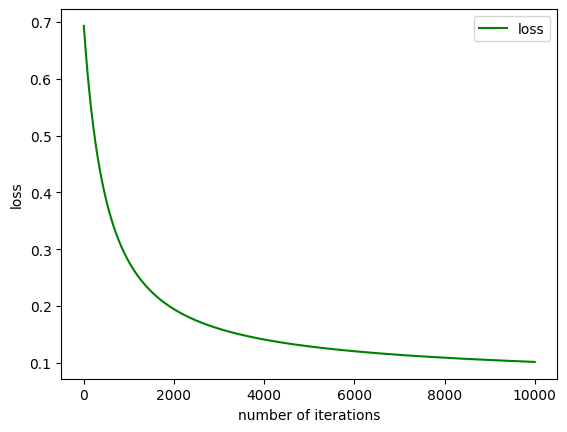

In [24]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((3, 1)), 1e-9, 10000)

In [25]:
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

The cost after training is 0.10157921.
The resulting vector of weights is [np.float64(3e-07), np.float64(0.00127323), np.float64(-0.001111)]


In [27]:

# Task 1: Train & Compare Logistic Regression
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, w)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
train_x_vec = np.zeros((len(train_x),3))
for i in range(len(train_x)):
    train_x_vec[i,:] = extract_features(train_x[i],freqs)
test_x_vec = np.zeros((len(test_x),3))
for i in range(len(test_x)):
    test_x_vec[i,:] = extract_features(test_x[i],freqs)

model = LogisticRegression()
model.fit(train_x_vec, train_y.ravel())
y_pred = model.predict(test_x_vec)
accuracy = accuracy_score(test_y, y_pred)
print("Sklearn Logistic Accuracy:", accuracy)

Logistic regression model's accuracy = 0.9960
Sklearn Logistic Accuracy: 0.995


In [28]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, w)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.47137167	b'uff itna miss karhi thi ap :p'


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18440\2367174779.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	0.53251630	b'u prob fun david'
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
0	0.50095500	b'pat jay'
THE TWEET IS: @bae_ts WHATEVER STIL L YOUNG &gt;:-(
THE PROCESSED TWEET IS: ['whatev', 'stil', 'l', 'young', '>:-(']
0	0.50032454	b'whatev stil l young >:-('
THE TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf
THE PROCESSED TWEET IS: ['belov', 'grandmoth']
0	0.50000008	b'belov grandmoth'
THE TWEET IS: @CHEDA_KHAN Thats life. I get calls from people I havent seen in 20 years and its always favours : (
THE PROCESSED TWEET IS: ['that', 'life', 'get', 'call', 'peopl', 'havent', 'seen', '20', 'year', 'alway', 'favour']
0	0.50564988	b'that life get call peopl havent seen 20 year alway favour'
THE TWEET IS: Sr. Financial Analyst - Expedia, Inc.: (#Bellevue, WA) http://t.co/ktknMhvwCI #Finance #ExpediaJobs #Job #Jobs #Hiring
THE PROCES

In [29]:
print('Label Predicted Tweet (sklearn)')
for x,y in zip(test_x, test_y):   # ở đây phải dùng tweet gốc
    x_vec = extract_features(x, freqs)   # build feature vector (giống khi train sklearn)
    y_hat = model.predict(x_vec)[0]      # dùng model đã fit
    if y != y_hat:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('True label:', y, 'Predicted:', y_hat)


Label Predicted Tweet (sklearn)
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
True label: [1.] Predicted: 0.0
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
True label: [1.] Predicted: 0.0
THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
True label: [0.] Predicted: 1.0
THE TWEET IS: @bumkeyyfel b-butt : ( isn't black cat a bad luck ene
THE PROCESSED TWEET IS: ['b-butt', 'black', 'cat', 'bad', 'luck', 'ene']
True label: [0.] Predicted: 1.0
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
True label: [0.] Predicted: 1.0
THE TWEET IS:

In [30]:
def classify_tweet(tweet, freqs, process_tweet=process_tweet):
    """
    Classify a tweet based on frequency counts (rule-based decision function).

    Input:
        tweet: a string (the raw tweet)
        freqs: dictionary {(word,label): count} built from training set
        process_tweet: preprocessing function (tokenization, stopword removal,...)

    Output:
        1 if positive frequency > negative frequency
        0 otherwise
    """
    # tiền xử lý tweet thành list token
    tokens = process_tweet(tweet)

    # tính tổng tần suất từ trong freqs
    pos_count = sum(freqs.get((word, 1), 0) for word in tokens)
    neg_count = sum(freqs.get((word, 0), 0) for word in tokens)

    # quyết định
    if pos_count > neg_count:
        return 1
    else:
        return 0


In [38]:
def compute_precision_logistic_regression(test_x, test_y, freqs, theta):
    true_pos = 0
    false_pos = 0
    for tweet, actual in zip(test_x, test_y):
        predicted = predict_tweet(tweet, freqs, theta)
        if predicted > 0.5:
            if actual == 1:
                true_pos += 1
            else:
                false_pos += 1
    precision = true_pos/(true_pos+false_pos)
    return precision

def compute_precision(test_x, test_y, freqs):
    true_pos = 0
    false_pos = 0
    for tweet, actual in zip(test_x, test_y):
        predicted = classify_tweet(tweet, freqs)
        if predicted == 1:
            if actual == 1:
                true_pos += 1
            else:
                false_pos += 1
    precision = true_pos/(true_pos+false_pos)
    return precision

def compare_precisions(test_x, test_y, freqs, theta):
    """
    Compare precision of logistic regression vs frequency-based classifier.
    """
    prec_log = compute_precision_logistic_regression(test_x, test_y, freqs, theta)
    prec_freq = compute_precision(test_x, test_y, freqs)

    print(f"Precision (Logistic Regression): {prec_log:.4f}")
    print(f"Precision (Frequency-based):    {prec_freq:.4f}")

compare_precisions(test_x, test_y, freqs, w)

Precision (Logistic Regression): 0.9930
Precision (Frequency-based):    0.9960


| **CRITERIA**       | **LOGISTIC REGRESSION**                        | **FREQUENCY-BASED DECISION FUNCTION**              |
|---------------------|-----------------------------------------------|----------------------------------------------------|
| **Precision**       | ≈ 0.9930                                      | ≈ 0.9960                                           |
| **Sensitivity**     | Sensitive to feature interactions and correlations | Less sensitive, purely based on positive vs negative word counts |
| **Model Complexity**| Weighted linear combination of features, requires training | Very simple, only compares word counts              |
| **Overfitting Risk**| Moderate; requires regularization to avoid overfitting | Low; due to simple, rule-based approach             |
| **Interpretability**| Moderate: weights give some insight, but still complex | High: easy to interpret directly from word frequencies |
| **Generalization**  | Better generalization to diverse datasets      | May struggle with complex or unseen words/contexts  |
